<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/VideoAnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Real-Time Crime Prevention using Video Anomaly Detection




**Comparative** Analysis of Pretrained Video Classification models in detecting real-time shooting crime for peace and safety

## Data Collection

A sub-set of UCF-Crime dataset is used for this research work. It contains 128 hours of video, comprising 1900 long untrimmed real world surveillance videos, with 13 realistic anomalies as well as normal activities (Sultani et al., *2018*).

This research uses the shooting dataset only to fine-tune selected video classification pretrained models, compares and evaluate their performance.

### Specify Dataset Location & Import Dependencies

Import package dependencies and define variables for datasets and pretrained model.

Video Swim a pure transformer based video modeling algorithm with its pretrained model is used for feature extraction and fine-tuned with the shooting dataset for classifying videos as shooting or non shooting videos (Liu et al.,2022).



In [1]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import cv2
import shutil
import pandas as pd
import shutil
import numpy as np
from sklearn.utils import shuffle as sk_shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
import pandas as pd
from IPython.display import HTML, display
import time
import gc
import random
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers


"""
Seeding to achieving consistent results across training and inference sessions.
"""

# Seed value
seed_value = 42

# Set python built-in pseudo-random generator
random.seed(seed_value)

# Set numpy pseudo-random generator
np.random.seed(seed_value)

# Set tensorflow pseudo-random generator
tf.random.set_seed(seed_value)

# Set PYTHONHASHSEED environment variable
os.environ['PYTHONHASHSEED'] = str(seed_value)


base_directory = '/content/drive/MyDrive/VideoAnomalyDetection/'
base_dataset_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'
saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'
train_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Anomaly_Train_2.txt'


# Read Dataset

In [2]:
def read_video_paths_from_file(file_path, base_dataset_dir):
    full_file_path = os.path.join(base_dataset_dir, file_path)

    with open(full_file_path, 'r') as file:
        # Concatenate base_dataset_dir with each path read from the file
        paths = [os.path.join(base_dataset_dir, line.strip()) for line in file]

    return paths

def filter_video_paths(paths, filter_keyword):
    return [path for path in paths if filter_keyword.lower() in path.lower()]


def filter_video_paths_by_anomaly_type(paths, anomaly_type):
    """Filter video paths based on a specific anomaly type."""
    return [path for path in paths if anomaly_type.lower() in path.lower()]


# Read video paths from the file
video_paths = read_video_paths_from_file(train_file_path,base_dataset_dir)

# Use "Shooting" and "Normal" to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')
"""
for anomaly_path in anomaly_videos:
    print(anomaly_path)

for normal_path in normal_videos:
    print(normal_path)
"""


'\nfor anomaly_path in anomaly_videos:\n    print(anomaly_path)\n\nfor normal_path in normal_videos:\n    print(normal_path)\n'

# Data Preprocessing

Resize, normalize and split videos into frames. Batch frames in 32 segments.

Use data generators to prevent loading large datset into memory at once, to better utilize memory for resource constrained environement.

Generator loads and preprocess 32 frames at each interval.

In [3]:
def can_read_file(file_path):
    """Attempt to open and read a small portion of the file."""
    try:
        with open(file_path, 'rb') as file:
            file.read(1)
        return True
    except Exception as e:
        print(f"Unable to read file {file_path}: {e}")
        return False

def preprocess_and_segment_video(video_path, resize_shape=(224, 224), segment_length=32):
    """
    Generator to preprocess raw videos by resizing, converting color space, and normalization.
    Includes checks for common file access issues.
    """
    # Check if the file exists
    if not os.path.exists(video_path):
        print(f"File does not exist: {video_path}")
        return

    # Check if the file can be read (covers permissions and potentially other read-related errors)
    if not can_read_file(video_path):
        # can_read_file will print the specific error
        return

    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"OpenCV could not open video file for an unknown reason: {video_path}")
    except Exception as e:
        print(f"Error: {e}")
        return

    frames_count = 0
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # Check if the frame is actually non-empty to avoid processing empty arrays
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue  # Skip this frame and move to the next
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)
            frames_count += 1
            if frames_count == segment_length:
                yield np.stack(frames, axis=0)
                frames_count = 0
                frames.clear()
    except Exception as e:
        print(f"Error processing video {video_path}: {e}")
    finally:
        cap.release()

    if frames_count > 0:
        while frames_count < segment_length:
            frames.append(np.zeros(resize_shape + (3,), dtype=np.float32))
            frames_count += 1
        yield np.stack(frames, axis=0)


all_videos = anomaly_videos + normal_videos
"""
for video_path in all_videos:
    for segment in preprocess_and_segment_video(video_path):
        print(f"Segment shape: {segment.shape} : {video_path}")
"""


'\nfor video_path in all_videos:\n    for segment in preprocess_and_segment_video(video_path):\n        print(f"Segment shape: {segment.shape} : {video_path}")\n'

#Video Processing Utilities

In [4]:
def list_video_files(directory, extension='mp4'):
    """
    List all video files in the given directory with the specified extension.

    Parameters:
    - directory: Path to the directory to search for video files.
    - extension: Extension of the video files to search for (default is '*.mp4').

    Returns:
    - A list of paths to the video files found.
    """
     # Check if the directory exists
    if not os.path.exists(directory):
        print(f"Error: Directory does not exist - {directory}")
        return []  # Return an empty list instead of None

    # Check if the directory can be accessed (read permissions)
    if not os.access(directory, os.R_OK):
        print(f"Error: Directory cannot be read, check permissions - {directory}")
        return []  # Return an empty list instead of None

    # Perform a recursive search for video files
    pattern = os.path.join(directory, '**', f'*.{extension}')
    _video_files = glob.glob(pattern, recursive=True)
    return _video_files


def shuffle_together(video_paths, labels):
    """
    Shuffle two lists in unison.

    Parameters:
    - video_paths: The first list to shuffle.
    - label: The second list to shuffle, must be the same length as list1.

    Returns:
    - The shuffled video_paths and label.
    """
    if len(video_paths) != len(labels):
        raise ValueError("The lists to be shuffled must be the same length.")

    # sklearn's shuffle function to shuffle both lists in unison
    video_paths_shuffled, label_shuffled = shuffle(video_paths, labels)
    return video_paths_shuffled, label_shuffled

def get_total_frames(video_path):
    """
    Returns the total number of frames in a video.

    Parameters:
    - video_path: The path to the video file.

    Returns:
    - The total number of frames as an integer.
    """
    # Initialize the video capture object with the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Failed to open video file: {video_path}")
        return 0  # Indicates that the video could not be opened

    # Get the total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Release the video capture object
    cap.release()

    return total_frames

def segments_per_video(video_path, segment_length=32):
    total_frames = get_total_frames(video_path)  # This function needs to return the total frame count
    segments = 0
    if total_frames != 0:
          segments = total_frames // segment_length
          if total_frames % segment_length != 0:
              segments += 1  # Account for the last, potentially shorter, segment
    print("{} frames, {} segments for {}".format(total_frames,segments,video_path))
    return segments
"""
video_path = anomaly_videos[0]
total_segments = segments_per_video(video_path, segment_length=32)
print(f"Total segments: {total_segments}")
"""

'\nvideo_path = anomaly_videos[0]\ntotal_segments = segments_per_video(video_path, segment_length=32)\nprint(f"Total segments: {total_segments}")\n'

#Generate Features and Labels

In [5]:
def create_dataset_from_videos(video_paths, labels, resize_shape=(224, 224), segment_length=32):
    """
    Creates a TensorFlow dataset of video segments with corresponding labels.

    Args:
        video_paths (list of str): Paths to video files.
        labels (list of int): Labels for each video file.
        resize_shape (tuple): The target shape for resizing frames.
        segment_length (int): Number of frames per video segment.

    Returns:
        tf.data.Dataset: A dataset of video segments and labels.
    """
    def generator():
        count = 0;
        for video_path, label in zip(video_paths, labels):
            count = count + 1;
            video_gen = preprocess_and_segment_video(video_path, resize_shape, segment_length)
            print("Video files count: {} processing: {}".format(count, video_path))
            # Iterate over the generator and yield its items
            for segment in video_gen:  # Iterate over items yielded by video_gen
                yield segment, label
            """
            if features is not None:
                # Yield features and label if processing was successful
                yield features, label
            else:
                print(f"Skipping video {video_path}, unable to process.")
            """
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(segment_length, *resize_shape, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )



# Fine-Tune Pretrained Video Swin Transformer Model for Video Classification

In [6]:
def build_finetune_model():
    """
    Fine-tune pretrained model.

    Parameters:
        saved_model_path (str): Path to the saved Video Swin Transformer model.

    Returns:
        model (keras.Model): Fine-tuned model for shooting classification.
    """
    # Load the pretrained Video Swin model
    video_swin = load_model(saved_model_path, compile=False)

    # Fine-tuning configuration: set the last N layers to be trainable
    # N=1, fine-tune the last layer of the pretrained model
    """
    N=1
    for layer in video_swin.layers[:-N]:
        layer.trainable = False
    for layer in video_swin.layers[-N:]:
        layer.trainable = True
    """
    # Set the entire Video Swin model to non-trainable
    video_swin.trainable = False

    # Downstream model for binary classification
    model = Sequential([
        video_swin,
        # Assume video_swin's output shape is compatible with the Dense layer's input
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization again if needed
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    return model


#Train the Fine-Tuned Model for Shooting Classification

In [7]:
# Define the base directory to save checkpoints
model_chkpt_filename = f"training_1/vad_{int(time.time())}.ckpt"
checkpoint_path = os.path.join(base_directory, model_chkpt_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create the base directory if it doesn't exist
os.makedirs(base_directory, exist_ok=True)

# Callbacks configuration
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_best_only=True,
        monitor='val_loss'),  # Save the best model based on val_loss
    EarlyStopping(
        monitor='val_loss',
        verbose=1,
        patience=10),  # Stop training when `val_loss` is no longer improving
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5),  # Reduce learning rate when `val_loss` plateaus
    TensorBoard(
        log_dir=os.path.join(base_directory, 'logs'),  # Path to save log files for TensorBoard in Google Drive
        histogram_freq=1,  # Record activation histograms every 1 epoch
        embeddings_freq=1)  # Record embedding data every 1 epoch
]


# Define a custom callback for clearing the session and collecting garbage
class ClearSessionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        tf.keras.backend.clear_session()
        gc.collect()

# Assume `callbacks_list` is already defined. Add the new callback to it.
callbacks_list.append(ClearSessionCallback())

## Multiple Instance Learning Loss

In [8]:
def mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01, margin=5.0):
    """
    MIL ranking loss with sparsity and smoothness constraints.

    Args:
    - sparsity_weight: Weight for the sparsity term.
    - smoothness_weight: Weight for the smoothness term.
    - margin: Margin for the ranking loss.

    Returns:
    - A loss function that takes (y_true, y_pred) as inputs.
    """

    def loss(y_true, y_pred):
        # Separate the anomaly scores into positive and negative samples based on the labels.
        positive_scores = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        negative_scores = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))

        # Calculate the highest scores for positive and negative samples.
        highest_positive_score = tf.reduce_max(positive_scores)
        highest_negative_score = tf.reduce_max(negative_scores)

        # Calculate ranking loss.
        ranking_loss = tf.maximum(0.0, margin - highest_positive_score + highest_negative_score)

        # Calculate sparsity loss (L1 norm of the predictions).
        sparsity_loss = tf.reduce_sum(tf.abs(y_pred))

        # Calculate smoothness loss (squared difference between adjacent anomaly scores).
        diffs = y_pred[:, 1:] - y_pred[:, :-1]
        smoothness_loss = tf.reduce_sum(tf.square(diffs))

        # Combine the losses using the weights and loss components.
        total_loss = ranking_loss + (sparsity_weight * sparsity_loss) + (smoothness_weight * smoothness_loss)

        return total_loss

    return loss

In [9]:
#anomaly_videos, normal_videos = list_video_files(anomaly_dir), list_video_files(normal_dir)
print("\nanomaly_videos", len(anomaly_videos))
print("\nnormal_videos", len(normal_videos))

video_paths = anomaly_videos + normal_videos
labels = [1] * len(anomaly_videos) + [0] * len(normal_videos)
print("\nvideo paths {} and labels {}".format(video_paths,labels))
video_paths, labels = shuffle_together(video_paths, labels)
print("\nShuffled: video paths {} and labels {}".format(video_paths,labels))
dataset = create_dataset_from_videos(video_paths, labels)


cache_data_filename = f"./cache.tf-data_{int(time.time())}"
dataset = dataset.cache(cache_data_filename)

"""
for features, label in dataset.take(3):
    print("\nFeatures shape:", features.numpy().shape)
"""

# calculate the total video segments i.e training dataset size
total_segments_actual = sum(segments_per_video(video_path, segment_length=32) for video_path in video_paths)
print(f"\nTotal segments across all videos: {total_segments_actual}")

"""
total_segments_actual = sum(1 for _ in dataset)
print("\nTotal segments actually in dataset:", total_segments_actual)
"""
# Calculate split sizes
train_data_size = int(total_segments_actual * 0.8)
print("\nTraining size split into :", train_data_size)


val_data_size = total_segments_actual - train_data_size

print("\nValidation size split into :", val_data_size)


# Ensure dataset is shuffled (use actual total size if known for better shuffling, uses more memory)
dataset = dataset.shuffle(buffer_size=(total_segments_actual//2),reshuffle_each_iteration=True)



"""
train_segments_split = sum(1 for _ in train_dataset)
print("\nTraining segments split:", train_segments_split)

val_segments_split = sum(1 for _ in val_dataset)
print("\nValidation segments split:", val_segments_split)

for features, label in train_dataset.take(1):
    print("Train: Features shape:", features.numpy().shape)
    print("Train: Label shape:", label.numpy())
    print("\nTrain: Labels:", label)

for features, label in val_dataset.take(1):
    print("\nVal: Features shape:", features.numpy().shape)
    print("val: Label shape:", label.numpy())
    print("val: Labels:", label)
"""


anomaly_videos 3

normal_videos 3

video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos002_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4'] and labels [1, 1, 1, 0, 0, 0]

Shuffled: video paths ['/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4', '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4',

'\ntrain_segments_split = sum(1 for _ in train_dataset)\nprint("\nTraining segments split:", train_segments_split)\n\nval_segments_split = sum(1 for _ in val_dataset)\nprint("\nValidation segments split:", val_segments_split)\n\nfor features, label in train_dataset.take(1):\n    print("Train: Features shape:", features.numpy().shape)\n    print("Train: Label shape:", label.numpy())\n    print("\nTrain: Labels:", label)\n\nfor features, label in val_dataset.take(1):\n    print("\nVal: Features shape:", features.numpy().shape)\n    print("val: Label shape:", label.numpy())\n    print("val: Labels:", label)\n'

In [10]:
def ensure_correct_dimensions(video_data, labels):
    # Now the function directly accepts video_data and labels as separate arguments

    # Define the expected shape, excluding batch size to allow dynamic sizes
    expected_shape = (32, 224, 224, 3)  # Example: (segments, height, width, channels)

    # Ensure the shape of the video data matches the expected shape, excluding the batch size
    tf.debugging.assert_equal(tf.shape(video_data)[1:], expected_shape, message="Video batch dimensions are incorrect")

    # Return video_data and labels unchanged
    return video_data, labels


In [11]:
checkpoint_prefix = '/content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711678818'


# Batch for memory efficiency
batch_size = 8
num_epochs = 10

train_dataset = dataset.take(train_data_size)
train_dataset = train_dataset.shuffle(buffer_size=train_data_size).repeat(num_epochs).batch(batch_size)
cache_train_filename = f"./cache.tf-train_{int(time.time())}"
dataset = dataset.cache(cache_train_filename)

val_dataset = dataset.skip(val_data_size)
val_dataset = val_dataset.shuffle(buffer_size=val_data_size).repeat(num_epochs).batch(batch_size)


val_dataset = train_dataset.cache(filename="./cache.tf-val")
cache_val_filename = f"./cache.tf-val_{int(time.time())}"
dataset = dataset.cache(cache_val_filename)

train_dataset = train_dataset.map(ensure_correct_dimensions)
val_dataset = val_dataset.map(ensure_correct_dimensions)

"""
for features, label in train_dataset.take(1):
    print("Train: Labels:", label.numpy())
    print("Train: Features shape:", features.numpy().shape)

for features, label in val_dataset.take(1):
    print("Val: Features shape:", features.numpy().shape)
    print("val: Labels:", label.numpy())
"""

training_steps_per_epoch = train_data_size // batch_size
validation_steps_per_epoch = val_data_size // batch_size

print("training_steps_per_epoch",training_steps_per_epoch)
print("validation_steps_per_epoch",validation_steps_per_epoch)


# Asynchronously fetch batches while model is training
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Configure the Adagrad optimizer
adagrad = Adagrad(learning_rate=0.01, epsilon=1e-08)

finetune_model = build_finetune_model()

# Define the checkpoint directory and prefix
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_prefix)

# Load the latest checkpoint if it exists
if latest_checkpoint:
    finetune_model.load_weights(latest_checkpoint)
    print(f"Checkpoint loaded: {latest_checkpoint}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Compile model with MIL loss, adam optimizer and metrics
finetune_model.compile(
    optimizer=adagrad,
    #loss=mil_ranking_loss(sparsity_weight=0.01, smoothness_weight=0.01),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

"""
for features, labels in train_dataset.take(1):
    print(features.shape)

for features, labels in val_dataset.take(1):
    print(features.shape)
"""
# Train the model
history = finetune_model.fit(
    train_dataset,
    epochs=num_epochs,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps_per_epoch,  # Add this line
    callbacks=callbacks_list,
    verbose=1
)


training_steps_per_epoch 16
validation_steps_per_epoch 4
No checkpoint found. Starting training from scratch.
Epoch 1/10
Video files count: 1 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting001_x264.mp4
Video files count: 2 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting012_x264.mp4
Video files count: 3 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos004_x264.mp4
Video files count: 4 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4
Error: OpenCV could not open video file for an unknown reason: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting023_x264.mp4
Video files count: 5 processing: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos002_x264.mp4
Video files count: 6 processing: /content/drive/MyDrive/VideoAnomalyDetec

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Evaluate Final Model Performance

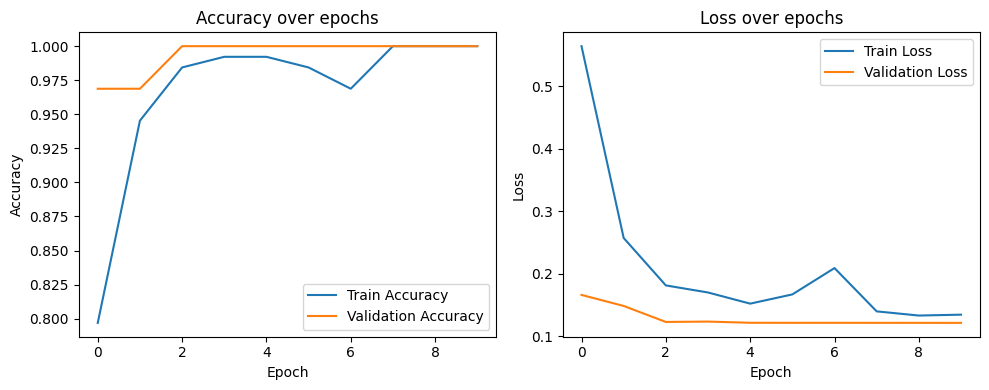

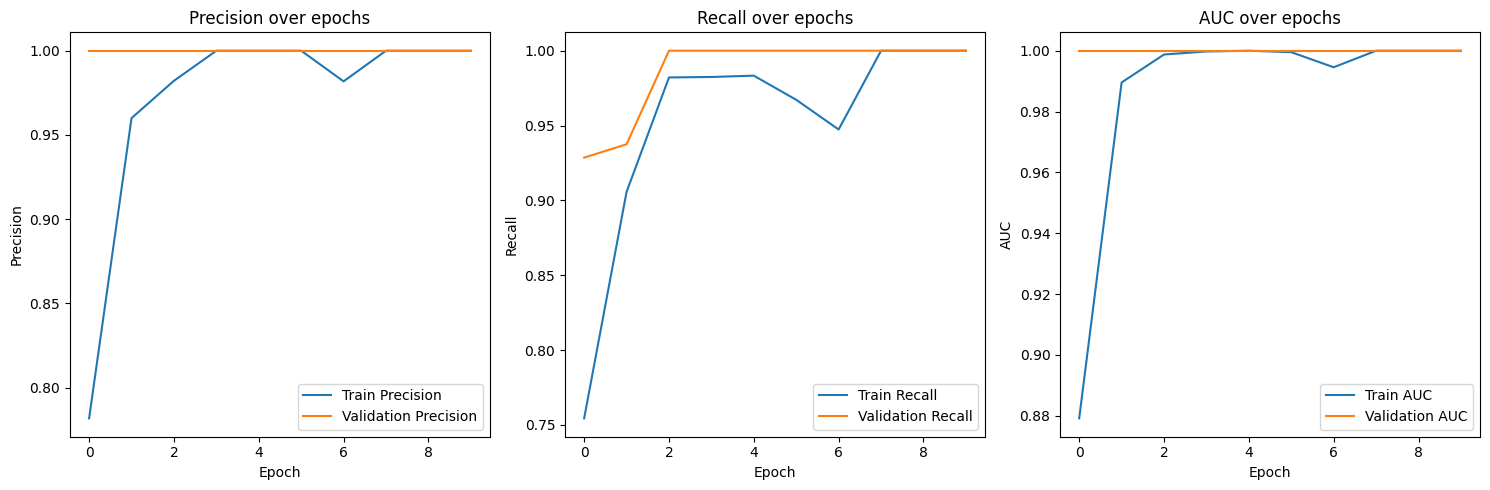

In [13]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot precision, recall, and AUC
plt.figure(figsize=(15, 5))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall over epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC over epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

# Test Fine-Tuned Model


In [14]:
# Define the path to your training file
test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/UCF_Crimes-Train-Test-Split/Anomaly_Detection_splits/Anomaly_Test.txt'


# Read video paths from the file
video_paths = read_video_paths_from_file(test_file_path,base_dataset_dir)

# Assuming the directory names "Anomaly" and "Normal" are part of the paths to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')[:27]

for anomaly_path in anomaly_videos:
    print(anomaly_path)

for normal_path in normal_videos:
    print(normal_path)

# Preprocess the video
test_video_data = preprocess_and_segment_video(anomaly_videos[0], (224,224), 32)

test_video_data = np.expand_dims(test_video_data, axis=0)  # Add batch dimension

# Load the fine-tuned model
model = tf.keras.models.load_model(latest_checkpoint)

# Make predictions
predictions = model.predict(test_video_data)

# Define an anomaly threshold
anomaly_threshold = 0.5  # This is arbitrary; adjust based on your model and use case

# Check if any segment is predicted as anomalous
is_anomalous = np.any(predictions > anomaly_threshold)

print(f"Video is {'anomalous' if is_anomalous else 'normal'}")



/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting002_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting004_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting007_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting008_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting010_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting011_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting013_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting015_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting018_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting019_x264.mp4
/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Shooting/Shooting021_x264.mp4
/content/d

OSError: Unable to load model. Filepath is not an hdf5 file (or h5py is not available) or SavedModel. Received: filepath=None